# Privacy Attacks

In [1]:
import os
import matplotlib.pyplot as plt

import torch
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [2]:
torch.set_num_threads(1)
cwd = os.path.join(os.getcwd(), '..', '..')

p_indian_list = [0.005, 0.01, 0.05,
                 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9,
                 0.95, 0.99, 0.995]
out_rate = 1000

## Attack sketches

In [3]:
all_cores_dir = os.path.join(cwd, 'results', '6_privacy', 'fffc_tiny', 'cores')

acc_diffs_cores = []
for p in p_indian_list:
    p_acc_diff = []
    for idx in range(10):
        cores_dir = os.path.join(all_cores_dir, str(p), str(idx))
        files_lst = os.listdir(cores_dir)
        for f in files_lst:
            test_acc = float(f.split('_')[1])
            sketch_acc = float(f.split('_')[2][:-3])
            p_acc_diff.append(sketch_acc - test_acc)
        
    p_acc_diff = torch.Tensor(p_acc_diff)
    acc_diffs_cores.append((p, (p_acc_diff.mean(), p_acc_diff.std())))

acc_diffs_cores = dict(acc_diffs_cores)
acc_diffs_cores

{0.005: (tensor(0.0359), tensor(0.0326)),
 0.01: (tensor(0.0321), tensor(0.0342)),
 0.05: (tensor(0.0187), tensor(0.0339)),
 0.1: (tensor(0.0100), tensor(0.0367)),
 0.2: (tensor(0.0186), tensor(0.0376)),
 0.3: (tensor(0.0053), tensor(0.0377)),
 0.5: (tensor(0.0103), tensor(0.0414)),
 0.7: (tensor(0.0066), tensor(0.0432)),
 0.8: (tensor(-0.0006), tensor(0.0444)),
 0.9: (tensor(0.0127), tensor(0.0449)),
 0.95: (tensor(0.0055), tensor(0.0414)),
 0.99: (tensor(0.0090), tensor(0.0422)),
 0.995: (tensor(0.0023), tensor(0.0433))}

In [4]:
all_recores_dir = os.path.join(cwd,'results', '6_privacy', 'fffc_tiny', 'recores')

acc_diffs_recores = []
for p in p_indian_list:
    p_acc_diff = []
    for idx in range(10):
        recores_dir = os.path.join(all_recores_dir, str(p), str(idx))
        files_lst = os.listdir(recores_dir)
        for f in files_lst:
            test_acc = float(f.split('_')[1])
            sketch_acc = float(f.split('_')[2][:-3])
            p_acc_diff.append(sketch_acc - test_acc)
        
    p_acc_diff = torch.Tensor(p_acc_diff)
    acc_diffs_recores.append((p, (p_acc_diff.mean(), p_acc_diff.std())))

acc_diffs_recores = dict(acc_diffs_recores)
acc_diffs_recores

{0.005: (tensor(-0.0008), tensor(0.0286)),
 0.01: (tensor(0.0067), tensor(0.0279)),
 0.05: (tensor(-0.0011), tensor(0.0304)),
 0.1: (tensor(0.0004), tensor(0.0312)),
 0.2: (tensor(-0.0008), tensor(0.0353)),
 0.3: (tensor(0.0013), tensor(0.0351)),
 0.5: (tensor(0.0012), tensor(0.0377)),
 0.7: (tensor(-0.0021), tensor(0.0382)),
 0.8: (tensor(-0.0032), tensor(0.0357)),
 0.9: (tensor(0.0146), tensor(0.0299)),
 0.95: (tensor(0.0062), tensor(0.0323)),
 0.99: (tensor(-0.0005), tensor(0.0385)),
 0.995: (tensor(0.0036), tensor(0.0388))}

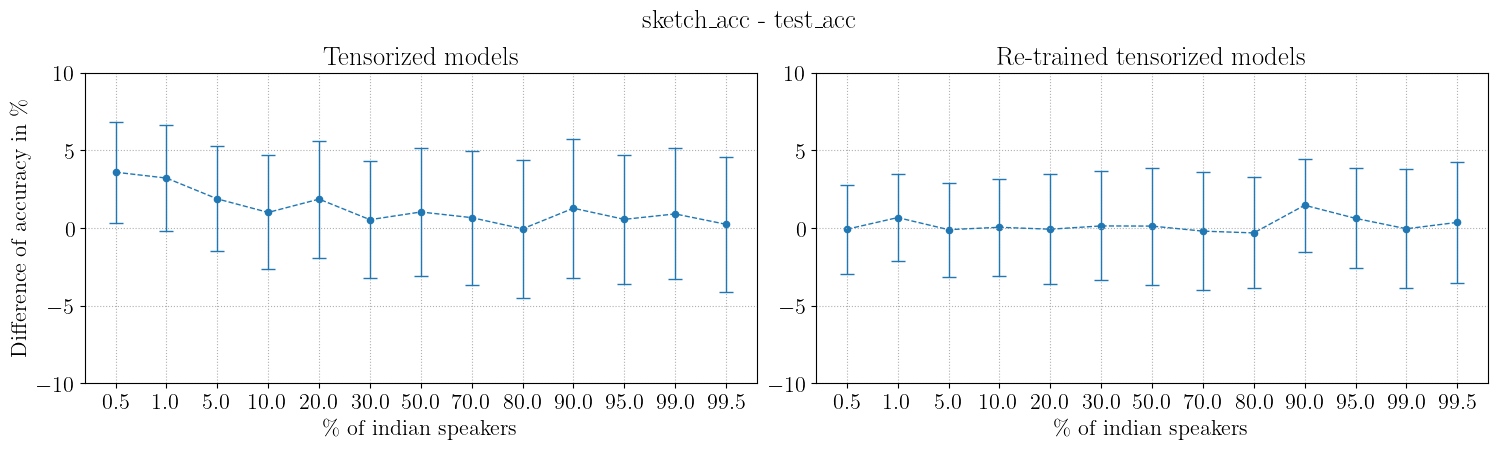

In [5]:
# plt.rc('font', family='serif', size=15)
plt.rc('font', family='serif', serif='Computer Modern', size=16)
plt.rc('text', usetex=True)

colormap = plt.get_cmap("tab10")
# colors = ['black', 'tab:blue', 'tab:orange', 'tab:green']

fig, axs = plt.subplots(1, 2, figsize=(15, 4.5))
p_str = [str(p * 100) for p in p_indian_list]

# Cores
# -----
means = torch.stack(list(map(lambda t: t[0] * 100,
                             acc_diffs_cores.values()))).tolist()
stds = torch.stack(list(map(lambda t: t[1] * 100,
                            acc_diffs_cores.values()))).tolist()

axs[0].errorbar(x=p_str, y=means, yerr=stds, capsize=5.,
                linestyle='--', linewidth=1., color='tab:blue')
axs[0].scatter(x=p_str, y=means, marker='o', s=20., color='tab:blue')

# Set axes
axs[0].set_xlabel('\% of indian speakers')
axs[0].set_ylabel('Difference of accuracy in \%')
axs[0].set_title('Tensorized models')

axs[0].set_ylim(-10, 10)
axs[0].yaxis.grid(linestyle=':')
axs[0].xaxis.grid(linestyle=':')

# Recores
# -------
means = torch.stack(list(map(lambda t: t[0] * 100,
                             acc_diffs_recores.values()))).tolist()
stds = torch.stack(list(map(lambda t: t[1] * 100,
                            acc_diffs_recores.values()))).tolist()

axs[1].errorbar(x=p_str, y=means, yerr=stds, capsize=5.,
                linestyle='--', linewidth=1., color='tab:blue')
axs[1].scatter(x=p_str, y=means, marker='o', s=20., color='tab:blue')

# Set axes
axs[1].set_xlabel('\% of indian speakers')
axs[1].set_title('Re-trained tensorized models')

axs[1].set_ylim(-10, 10)
axs[1].yaxis.grid(linestyle=':')
axs[1].xaxis.grid(linestyle=':')


fig.suptitle('sketch_acc - test_acc')

plt.tight_layout(pad=0.5)
plt.show()

## NNs

In [4]:
combs = [(0, 0), (0, 1), (1, 0), (1, 1)]

accs_by_comb = []
for l, k in combs:
    accs = {}
    for p in p_indian_list:
        aux_acc = torch.load(
            os.path.join(cwd, 'results', '6_privacy', 'fffc_tiny',
                         'attacks_softmax_test_samples', 'acc_by_class',
                         str(p), f'{l}_{k}.pt'),
            weights_only=False)
        accs[p] = aux_acc
    accs_by_comb.append(accs)

accs_by_comb

[{0.005: (tensor(0.6430), tensor(0.0321)),
  0.01: (tensor(0.6478), tensor(0.0299)),
  0.05: (tensor(0.6674), tensor(0.0314)),
  0.1: (tensor(0.6985), tensor(0.0329)),
  0.2: (tensor(0.7521), tensor(0.0324)),
  0.3: (tensor(0.8008), tensor(0.0313)),
  0.5: (tensor(0.8591), tensor(0.0246)),
  0.7: (tensor(0.8962), tensor(0.0193)),
  0.8: (tensor(0.9080), tensor(0.0162)),
  0.9: (tensor(0.9169), tensor(0.0138)),
  0.95: (tensor(0.9230), tensor(0.0134)),
  0.99: (tensor(0.9267), tensor(0.0121)),
  0.995: (tensor(0.9254), tensor(0.0134))},
 {0.005: (tensor(0.9573), tensor(0.0132)),
  0.01: (tensor(0.9561), tensor(0.0138)),
  0.05: (tensor(0.9504), tensor(0.0142)),
  0.1: (tensor(0.9498), tensor(0.0148)),
  0.2: (tensor(0.9461), tensor(0.0152)),
  0.3: (tensor(0.9436), tensor(0.0156)),
  0.5: (tensor(0.9400), tensor(0.0153)),
  0.7: (tensor(0.9249), tensor(0.0188)),
  0.8: (tensor(0.9160), tensor(0.0195)),
  0.9: (tensor(0.9010), tensor(0.0192)),
  0.95: (tensor(0.9020), tensor(0.0214)),
  

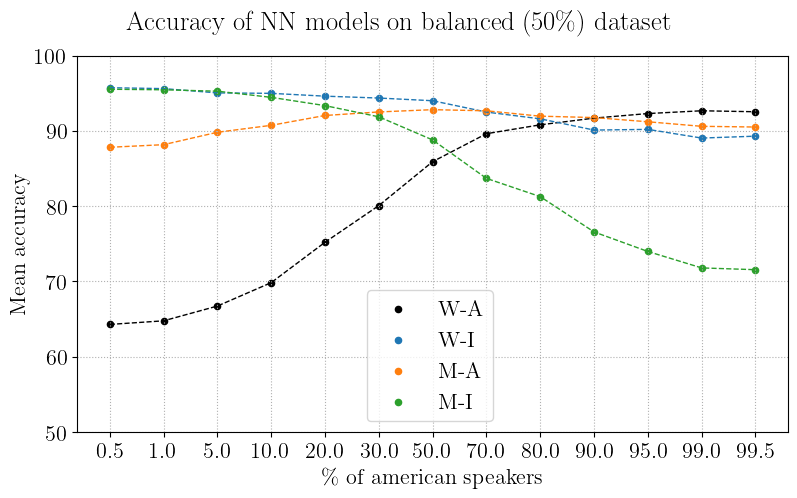

In [7]:
# plt.rc('font', family='serif', size=15)
plt.rc('font', family='serif', serif='Computer Modern', size=16)
plt.rc('text', usetex=True)

colormap = plt.get_cmap("tab10")
colors = ['black', 'tab:blue', 'tab:orange', 'tab:green']

labels = ['W-A', 'W-I', 'M-A', 'M-I']

fig, axs = plt.subplots(1, 1, figsize=(8, 5))
p_str = [str(p * 100) for p in p_indian_list]

# NNs
# ---

for i in range(4):
    means = torch.stack(list(map(lambda t: t[0] * 100,
                                 accs_by_comb[i].values()))).tolist()
    stds = torch.stack(list(map(lambda t: t[1] * 100,
                                accs_by_comb[i].values()))).tolist()

    # axs.errorbar(x=p_str, y=means, yerr=stds, capsize=5.,
    #              linestyle='--', linewidth=1., color=colors[i])
    axs.plot(p_str, means, linestyle='--', linewidth=1., color=colors[i])
    axs.scatter(x=p_str, y=means, marker='o', s=20., color=colors[i],
                label=labels[i])

# Set axes
axs.set_xlabel('\% of american speakers')
axs.set_ylabel('Mean accuracy')

axs.legend(loc='lower right', bbox_to_anchor=(0.6, 0.))

axs.set_ylim(50, 100)
axs.yaxis.grid(linestyle=':')
axs.xaxis.grid(linestyle=':')


fig.suptitle('Accuracy of NN models on balanced (50\%) dataset')

plt.tight_layout(pad=0.5)
plt.show()

In [13]:
# Create BB dataset
results_dir = os.path.join(cwd, 'results', '6_privacy',
                           'fffc_tiny', 'attacks_softmax_same_test_samples', 'nn')

datasets = {}
for p in [0.3]: #p_indian_list[:6]:
    # print(p)
    samples = []
    labels = []
    sizes = []
    for idx in range(10):
        # print('\t', idx)
        for s in range(25):
            # print('\t\t', s)
            for aux_p in [p, 1 - p]:
                # print('\t\t\t', aux_p)
                sample, size = torch.load(
                    os.path.join(results_dir, str(aux_p), str(idx), f'{s}.pt'),
                    weights_only=False
                    )
                sample.requires_grad = False
                label = 0 if aux_p < 0.5 else 1
                
                samples.append(sample)
                labels.append(label)
                sizes.append(size)
    
    min_size = min(sizes)
    print(min_size)
    
    samples = torch.stack([s[:min_size] for s in samples], dim=0)
    labels = torch.Tensor(labels)
    
    datasets[p] = (samples, labels)

1559


In [15]:
# Black-box
for p in [0.3]:
    train_scores = []
    test_scores = []
    for i in range(10):
        train = torch.cat([torch.arange(0, i * 50),
                           torch.arange((i + 1) * 50, 500)], dim=0)
        test = torch.arange(i * 50, (i + 1) * 50)

        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        X_train = X[train]
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        y_train = y[train]
        
        X_test = X[test]
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        y_test = y[test]
        
        clf = LogisticRegression() #random_state=0)
        clf = clf.fit(X_train, y_train)
        
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean(), test_scores.std())

0.3 tensor(1.) tensor(0.9120) tensor(0.2365)


In [10]:
# Black-box only with american women
for p in p_indian_list[:6]:
    train_scores = []
    test_scores = []
    for i in range(10):
        train = torch.cat([torch.arange(0, i * 50),
                           torch.arange((i + 1) * 50, 500)], dim=0)
        test = torch.arange(i * 50, (i + 1) * 50)

        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        X_train = X[train]
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        y_train = y[train]
        
        X_test = X[test]
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        y_test = y[test]
        
        clf = LogisticRegression() #random_state=0)
        clf = clf.fit(X_train[:, :10], y_train)
        
        train_score = clf.score(X_train[:, :10], y_train)
        test_score = clf.score(X_test[:, :10], y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean())

0.005 tensor(0.9311) tensor(0.5200)
0.01 tensor(0.8951) tensor(0.5000)
0.05 tensor(1.) tensor(0.9400)
0.1 tensor(0.9987) tensor(0.7640)
0.2 tensor(0.8962) tensor(0.7080)
0.3 tensor(0.8264) tensor(0.4540)


In [11]:
# Black-box only with indian women
for p in p_indian_list[:6]:
    train_scores = []
    test_scores = []
    for i in range(10):
        train = torch.cat([torch.arange(0, i * 50),
                           torch.arange((i + 1) * 50, 500)], dim=0)
        test = torch.arange(i * 50, (i + 1) * 50)

        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        X_train = X[train]
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        y_train = y[train]
        
        X_test = X[test]
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        y_test = y[test]
        
        clf = LogisticRegression() #random_state=0)
        clf = clf.fit(X_train[:, 10:20], y_train)
        
        train_score = clf.score(X_train[:, 10:20], y_train)
        test_score = clf.score(X_test[:, 10:20], y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean())

0.005 tensor(0.8518) tensor(0.5000)
0.01 tensor(0.8376) tensor(0.3640)
0.05 tensor(0.7882) tensor(0.4380)
0.1 tensor(0.7482) tensor(0.4880)
0.2 tensor(0.8236) tensor(0.5880)
0.3 tensor(0.8762) tensor(0.6580)


In [12]:
# Black-box only with american men
for p in p_indian_list[:6]:
    train_scores = []
    test_scores = []
    for i in range(10):
        train = torch.cat([torch.arange(0, i * 50),
                           torch.arange((i + 1) * 50, 500)], dim=0)
        test = torch.arange(i * 50, (i + 1) * 50)

        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        X_train = X[train]
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        y_train = y[train]
        
        X_test = X[test]
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        y_test = y[test]
        
        clf = LogisticRegression() #random_state=0)
        clf = clf.fit(X_train[:, 20:30], y_train)
        
        train_score = clf.score(X_train[:, 20:30], y_train)
        test_score = clf.score(X_test[:, 20:30], y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean())

0.005 tensor(0.9609) tensor(0.7620)
0.01 tensor(0.9876) tensor(0.9120)
0.05 tensor(0.9256) tensor(0.5980)
0.1 tensor(0.6878) tensor(0.1500)
0.2 tensor(0.9336) tensor(0.5680)
0.3 tensor(0.8998) tensor(0.6780)


In [13]:
# Black-box only with indian women
for p in p_indian_list[:6]:
    train_scores = []
    test_scores = []
    for i in range(10):
        train = torch.cat([torch.arange(0, i * 50),
                           torch.arange((i + 1) * 50, 500)], dim=0)
        test = torch.arange(i * 50, (i + 1) * 50)

        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        X_train = X[train]
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        y_train = y[train]
        
        X_test = X[test]
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        y_test = y[test]
        
        clf = LogisticRegression() #random_state=0)
        clf = clf.fit(X_train[:, 30:40], y_train)
        
        train_score = clf.score(X_train[:, 30:40], y_train)
        test_score = clf.score(X_test[:, 30:40], y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean())

0.005 tensor(0.9909) tensor(0.8040)
0.01 tensor(0.9413) tensor(0.5160)
0.05 tensor(0.9942) tensor(0.8560)
0.1 tensor(0.9844) tensor(0.6980)
0.2 tensor(0.9864) tensor(0.8860)
0.3 tensor(0.7064) tensor(0.2460)


In [14]:
# White-box
for p in p_indian_list[:6]:
    train_scores = []
    test_scores = []
    for i in range(10):
        train = torch.cat([torch.arange(0, i * 50),
                           torch.arange((i + 1) * 50, 500)], dim=0)
        test = torch.arange(i * 50, (i + 1) * 50)

        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        X_train = X[train]
        
        X_train_bb = X_train[:, :40]
        scaler = scaler.fit(X_train_bb)
        X_train_bb = scaler.transform(X_train_bb)
        
        X_train_wb = X_train[:, 40:]
        scaler = scaler.fit(X_train_wb)
        X_train_wb = scaler.transform(X_train_wb)
        
        X_train = torch.cat([torch.Tensor(X_train_bb),
                             torch.Tensor(X_train_wb)], dim=1)
        
        y_train = y[train]
        
        X_test = X[test]
        
        X_test_bb = X_test[:, :40]
        scaler = scaler.fit(X_test_bb)
        X_test_bb = scaler.transform(X_test_bb)
        
        X_test_wb = X_test[:, 40:]
        scaler = scaler.fit(X_test_wb)
        X_test_wb = scaler.transform(X_test_wb)
        
        X_test = torch.cat([torch.Tensor(X_test_bb),
                            torch.Tensor(X_test_wb)], dim=1)
        
        y_test = y[test]
        
        clf = LogisticRegression() #random_state=0)
        clf = clf.fit(X_train, y_train)
        
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean())

0.005 tensor(1.) tensor(0.9960)
0.01 tensor(1.) tensor(0.9980)
0.05 tensor(1.) tensor(1.)
0.1 tensor(1.) tensor(0.9980)
0.2 tensor(1.) tensor(0.9860)
0.3 tensor(1.) tensor(0.8980)


In [15]:
# Only white-box
for p in p_indian_list[:6]:
    train_scores = []
    test_scores = []
    for i in range(10):
        train = torch.cat([torch.arange(0, i * 50),
                           torch.arange((i + 1) * 50, 500)], dim=0)
        test = torch.arange(i * 50, (i + 1) * 50)

        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        X_train = X[train]
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        y_train = y[train]
        
        X_test = X[test]
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        y_test = y[test]
        
        clf = LogisticRegression() #random_state=0)
        clf = clf.fit(X_train[:, 40:], y_train)
        
        train_score = clf.score(X_train[:, 40:], y_train)
        test_score = clf.score(X_test[:, 40:], y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean())

0.005 tensor(1.) tensor(0.9960)
0.01 tensor(1.) tensor(0.9980)
0.05 tensor(1.) tensor(1.)
0.1 tensor(1.) tensor(0.9980)
0.2 tensor(1.) tensor(0.9840)
0.3 tensor(1.) tensor(0.8940)


In [16]:
X, y = datasets[0.3]

In [17]:
# Modelos en mayoria india
y[torch.arange(0, 500, 2)].mean()

tensor(0.)

In [18]:
# Mujeres
((X[torch.arange(0, 500, 2), :20] > 0.5).sum(dim=1) / 100).mean()

tensor(0.1770)

In [19]:
# Mujeres americanas
((X[torch.arange(0, 500, 2), :10] > 0.5).sum(dim=1) / 50).mean()

tensor(0.1646)

In [20]:
# Mujeres indias
((X[torch.arange(0, 500, 2), 10:20] > 0.5).sum(dim=1) / 50).mean()

tensor(0.1894)

In [21]:
# Hombres
((X[torch.arange(0, 500, 2), 20:40] > 0.5).sum(dim=1) / 100).mean()

tensor(0.0166)

In [22]:
# Hombres americanos
((X[torch.arange(0, 500, 2), 20:30] > 0.5).sum(dim=1) / 50).mean()

tensor(0.0122)

In [23]:
# Hombres indios
((X[torch.arange(0, 500, 2), 30:40] > 0.5).sum(dim=1) / 50).mean()

tensor(0.0210)

In [24]:
# Todos
((X[torch.arange(0, 500, 2), :40] > 0.5).sum(dim=1) / 200).mean()

tensor(0.0968)

In [25]:
# Modelos en mayoria americana
y[1 + torch.arange(0, 500, 2)].mean()

tensor(1.)

In [26]:
# Mujeres
((X[1 + torch.arange(0, 500, 2), :20] > 0.5).sum(dim=1) / 100).mean()

tensor(0.1820)

In [27]:
# Mujeres americanas
((X[1 + torch.arange(0, 500, 2), :10] > 0.5).sum(dim=1) / 50).mean()

tensor(0.1771)

In [28]:
# Mujeres indias
((X[1 + torch.arange(0, 500, 2), 10:20] > 0.5).sum(dim=1) / 50).mean()

tensor(0.1869)

In [29]:
# Hombres
((X[1 + torch.arange(0, 500, 2), 20:40] > 0.5).sum(dim=1) / 100).mean()

tensor(0.0295)

In [30]:
# Hombres americanos
((X[1 + torch.arange(0, 500, 2), 20:30] > 0.5).sum(dim=1) / 50).mean()

tensor(0.0288)

In [31]:
# Hombres indios
((X[1 + torch.arange(0, 500, 2), 30:40] > 0.5).sum(dim=1) / 50).mean()

tensor(0.0302)

In [32]:
# Todos
((X[1 + torch.arange(0, 500, 2), :40] > 0.5).sum(dim=1) / 200).mean()

tensor(0.1058)

In [33]:
X[:10, [0, 1, 2, 3, 4, 5]] 

tensor([[0.9999, 0.7759, 0.7492, 0.1076, 0.4215, 0.9255],
        [0.9621, 0.9995, 0.9985, 0.5016, 0.6154, 0.8897],
        [1.0000, 0.4416, 0.3346, 0.0210, 0.5135, 0.8550],
        [0.9673, 0.9945, 0.9950, 0.3364, 0.5262, 0.8208],
        [1.0000, 0.4608, 0.4455, 0.1970, 0.5401, 0.8830],
        [0.9447, 0.9998, 0.9998, 0.6937, 0.7111, 0.8854],
        [1.0000, 0.8050, 0.4080, 0.0273, 0.6132, 0.9426],
        [0.9336, 0.9961, 0.9948, 0.6624, 0.5975, 0.8831],
        [1.0000, 0.6691, 0.4491, 0.0428, 0.5670, 0.9386],
        [0.9668, 0.9980, 0.9976, 0.3405, 0.5547, 0.8639]])

In [34]:
(X[0, :10] - X[1, :10]).abs()

tensor([0.0378, 0.2236, 0.2493, 0.3940, 0.1939, 0.0358, 0.8060, 0.0422, 0.1995,
        0.0060])

In [35]:
(X[0, 10:20] - X[1, 10:20]).abs()

tensor([0.0832, 0.0014, 0.0275, 0.0084, 0.0063, 0.6414, 0.1629, 0.0416, 0.0011,
        0.3386])

In [36]:
X[:10, [0, 1, 10, 11, 20, 21, 30, 31]]

tensor([[9.9989e-01, 7.7588e-01, 9.9996e-01, 9.9860e-01, 1.0526e-01, 3.3426e-01,
         4.4634e-04, 9.7205e-03],
        [9.6210e-01, 9.9948e-01, 9.1676e-01, 9.9996e-01, 9.3805e-01, 7.4065e-01,
         8.6521e-03, 1.1505e-04],
        [1.0000e+00, 4.4157e-01, 9.9991e-01, 9.9956e-01, 1.3941e-01, 4.6897e-01,
         3.5081e-04, 7.2631e-04],
        [9.6727e-01, 9.9452e-01, 9.5384e-01, 9.9995e-01, 9.4670e-01, 7.6313e-01,
         7.1311e-03, 1.6752e-05],
        [1.0000e+00, 4.6083e-01, 9.9984e-01, 9.9886e-01, 1.5947e-01, 4.3380e-01,
         9.0508e-04, 2.6075e-02],
        [9.4473e-01, 9.9984e-01, 9.5699e-01, 9.9998e-01, 6.5013e-01, 8.1107e-01,
         9.2022e-03, 5.2748e-06],
        [1.0000e+00, 8.0502e-01, 9.9980e-01, 9.9875e-01, 1.5402e-01, 5.4588e-01,
         3.3173e-03, 1.8939e-02],
        [9.3358e-01, 9.9609e-01, 9.4721e-01, 1.0000e+00, 8.7305e-01, 8.4101e-01,
         2.0132e-02, 1.7228e-02],
        [1.0000e+00, 6.6908e-01, 9.9999e-01, 9.9971e-01, 1.1101e-01, 4.0961e-01,

In [37]:
y[:10]

tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1.])

In [38]:
X[50:60, [0, 1, 10, 11, 20, 21, 30, 31]]

tensor([[9.9612e-01, 9.9999e-01, 5.4366e-01, 9.9934e-01, 1.5921e-03, 7.0665e-03,
         1.6519e-01, 6.3771e-02],
        [9.9652e-01, 9.7781e-01, 9.7910e-01, 9.9981e-01, 1.5351e-01, 3.4564e-01,
         5.2037e-02, 2.3323e-03],
        [9.9171e-01, 9.9999e-01, 3.2353e-01, 9.9833e-01, 2.9477e-03, 3.9578e-03,
         2.9112e-01, 1.6051e-01],
        [9.9943e-01, 9.9698e-01, 9.7170e-01, 9.9998e-01, 3.3595e-01, 4.6233e-01,
         6.3908e-02, 3.6380e-03],
        [9.9004e-01, 9.9985e-01, 5.1365e-01, 9.9771e-01, 5.0905e-04, 2.5238e-02,
         2.2374e-01, 3.4644e-01],
        [9.9251e-01, 9.9342e-01, 9.8758e-01, 9.9965e-01, 2.4555e-01, 3.0112e-01,
         4.0842e-02, 2.4807e-03],
        [9.6704e-01, 9.9947e-01, 6.9893e-01, 9.9917e-01, 7.3505e-03, 6.4186e-03,
         3.1446e-01, 9.0423e-02],
        [9.9918e-01, 8.8322e-01, 9.7352e-01, 9.9978e-01, 1.3566e-01, 9.3399e-02,
         7.2002e-02, 6.7313e-03],
        [9.9971e-01, 1.0000e+00, 4.0091e-01, 9.9950e-01, 4.7887e-03, 1.7097e-02,

In [39]:
y[50:60]

tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1.])

In [40]:
X[100:110, [0, 1, 10, 11, 20, 21, 30, 31]]

tensor([[3.6176e-01, 9.9840e-01, 7.9168e-01, 9.7230e-01, 1.5027e-02, 2.8762e-04,
         2.2271e-03, 2.0231e-03],
        [9.9656e-01, 3.6651e-01, 9.6824e-01, 8.9285e-01, 2.9933e-01, 2.2813e-01,
         8.8186e-02, 1.4227e-01],
        [3.6885e-01, 9.9948e-01, 8.5881e-01, 9.9773e-01, 8.4838e-03, 1.0560e-03,
         7.0103e-03, 4.6404e-03],
        [9.9939e-01, 8.4046e-01, 9.9796e-01, 9.8186e-01, 3.8237e-01, 2.1504e-01,
         1.8048e-01, 5.2598e-01],
        [3.5168e-01, 9.9925e-01, 8.8654e-01, 9.9499e-01, 1.5890e-02, 4.0029e-04,
         7.8698e-03, 3.7557e-02],
        [9.9973e-01, 9.6111e-01, 9.9362e-01, 9.5187e-01, 4.0870e-01, 2.2969e-01,
         1.0204e-01, 1.6866e-01],
        [6.9065e-01, 9.9982e-01, 7.5772e-01, 9.9860e-01, 1.0722e-02, 4.8089e-05,
         2.1702e-03, 3.2098e-02],
        [9.9889e-01, 7.1370e-01, 9.9703e-01, 9.4514e-01, 2.6842e-01, 1.6693e-01,
         2.1508e-01, 5.3187e-01],
        [4.0153e-01, 9.8967e-01, 8.7750e-01, 9.9904e-01, 3.2990e-02, 6.2095e-04,

In [41]:
y[100:110]

tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1.])

## MPS

In [42]:
# Create BB dataset
results_dir = os.path.join(cwd, 'results', '6_privacy',
                           'fffc_tiny', 'attacks_softmax_test_samples', 'cores')

datasets = {}
for p in p_indian_list[:6]:
    samples = []
    labels = []
    for idx in range(10):
        for s in range(25):
            for aux_p in [p, 1 - p]:
                sample = torch.load(
                    os.path.join(results_dir, str(aux_p), str(idx), f'{s}.pt'),
                    weights_only=False
                    )
                sample.requires_grad = False
                label = 0 if aux_p < 0.5 else 1
                
                samples.append(sample)
                labels.append(label)
    
    min_len = samples[0].size(0)
    for s in samples[1:]:
        if s.size(0) < min_len:
            min_len = s.size(0)
    
    samples = [s[:min_len] for s in samples]
    
    samples = torch.stack(samples, dim=0)
    labels = torch.Tensor(labels)
    
    datasets[p] = (samples, labels)

In [43]:
# Black-box
for p in p_indian_list[:6]:
    train_scores = []
    test_scores = []
    for i in range(10):
        train = torch.cat([torch.arange(0, i * 50),
                           torch.arange((i + 1) * 50, 500)], dim=0)
        test = torch.arange(i * 50, (i + 1) * 50)

        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        X_train = X[train]
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        y_train = y[train]
        
        X_test = X[test]
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        y_test = y[test]
        
        clf = LogisticRegression() #random_state=0)
        clf = clf.fit(X_train[:, :40], y_train)
        
        train_score = clf.score(X_train[:, :40], y_train)
        test_score = clf.score(X_test[:, :40], y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean())

0.005 tensor(0.9987) tensor(0.6760)
0.01 tensor(0.9967) tensor(0.6620)
0.05 tensor(1.) tensor(0.9020)
0.1 tensor(1.) tensor(0.7300)
0.2 tensor(1.) tensor(0.7540)
0.3 tensor(0.9880) tensor(0.4860)


In [44]:
# White-box
for p in p_indian_list[:6]:
    train_scores = []
    test_scores = []
    for i in range(10):
        train = torch.cat([torch.arange(0, i * 50),
                           torch.arange((i + 1) * 50, 500)], dim=0)
        test = torch.arange(i * 50, (i + 1) * 50)

        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        X_train = X[train]
        
        X_train_bb = X_train[:, :40]
        scaler = scaler.fit(X_train_bb)
        X_train_bb = scaler.transform(X_train_bb)
        
        X_train_wb = X_train[:, 40:]
        scaler = scaler.fit(X_train_wb)
        X_train_wb = scaler.transform(X_train_wb)
        
        X_train = torch.cat([torch.Tensor(X_train_bb),
                             torch.Tensor(X_train_wb)], dim=1)
        
        y_train = y[train]
        
        X_test = X[test]
        
        X_test_bb = X_test[:, :40]
        scaler = scaler.fit(X_test_bb)
        X_test_bb = scaler.transform(X_test_bb)
        
        X_test_wb = X_test[:, 40:]
        scaler = scaler.fit(X_test_wb)
        X_test_wb = scaler.transform(X_test_wb)
        
        X_test = torch.cat([torch.Tensor(X_test_bb),
                            torch.Tensor(X_test_wb)], dim=1)
        
        y_test = y[test]
        
        clf = LogisticRegression() #random_state=0)
        clf = clf.fit(X_train, y_train)
        
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean())

0.005 tensor(1.) tensor(0.9660)
0.01 tensor(1.) tensor(0.9540)
0.05 tensor(1.) tensor(0.9660)
0.1 tensor(1.) tensor(0.9240)
0.2 tensor(1.) tensor(0.9560)
0.3 tensor(1.) tensor(0.9200)


In [45]:
# Only white-box
for p in p_indian_list[:6]:
    train_scores = []
    test_scores = []
    for i in range(10):
        train = torch.cat([torch.arange(0, i * 50),
                           torch.arange((i + 1) * 50, 500)], dim=0)
        test = torch.arange(i * 50, (i + 1) * 50)

        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        X_train = X[train]
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        y_train = y[train]
        
        X_test = X[test]
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        y_test = y[test]
        
        clf = LogisticRegression() #random_state=0)
        clf = clf.fit(X_train[:, 40:], y_train)
        
        train_score = clf.score(X_train[:, 40:], y_train)
        test_score = clf.score(X_test[:, 40:], y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean())

0.005 tensor(1.) tensor(0.9660)
0.01 tensor(1.) tensor(0.9540)
0.05 tensor(1.) tensor(0.9620)
0.1 tensor(1.) tensor(0.9240)
0.2 tensor(1.) tensor(0.9580)
0.3 tensor(1.) tensor(0.9220)


## Re-trained MPS

In [46]:
# Create BB dataset
results_dir = os.path.join(cwd, 'results', '6_privacy',
                           'fffc_tiny', 'attacks_softmax_test_samples', 'recores')

datasets = {}
for p in p_indian_list[:6]:
    samples = []
    labels = []
    for idx in range(10):
        for s in range(25):
            for aux_p in [p, 1 - p]:
                sample = torch.load(
                    os.path.join(results_dir, str(aux_p), str(idx), f'{s}.pt'),
                    weights_only=False
                    )
                sample.requires_grad = False
                label = 0 if aux_p < 0.5 else 1
                
                samples.append(sample)
                labels.append(label)
    
    min_len = samples[0].size(0)
    for s in samples[1:]:
        if s.size(0) < min_len:
            min_len = s.size(0)
    
    samples = [s[:min_len] for s in samples]
    
    samples = torch.stack(samples, dim=0)
    labels = torch.Tensor(labels)
    
    datasets[p] = (samples, labels)

In [47]:
# Black-box
for p in p_indian_list[:6]:
    train_scores = []
    test_scores = []
    for i in range(10):
        train = torch.cat([torch.arange(0, i * 50),
                           torch.arange((i + 1) * 50, 500)], dim=0)
        test = torch.arange(i * 50, (i + 1) * 50)

        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        X_train = X[train]
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        y_train = y[train]
        
        X_test = X[test]
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        y_test = y[test]
        
        clf = LogisticRegression() #random_state=0)
        clf = clf.fit(X_train[:, :40], y_train)
        
        train_score = clf.score(X_train[:, :40], y_train)
        test_score = clf.score(X_test[:, :40], y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean())

0.005 tensor(0.9980) tensor(0.7300)
0.01 tensor(1.) tensor(0.5100)
0.05 tensor(1.) tensor(0.9780)
0.1 tensor(0.9989) tensor(0.7720)
0.2 tensor(1.) tensor(0.8800)
0.3 tensor(1.) tensor(0.5620)


In [48]:
# White-box
for p in p_indian_list[:6]:
    train_scores = []
    test_scores = []
    for i in range(10):
        train = torch.cat([torch.arange(0, i * 50),
                           torch.arange((i + 1) * 50, 500)], dim=0)
        test = torch.arange(i * 50, (i + 1) * 50)

        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        X_train = X[train]
        
        X_train_bb = X_train[:, :40]
        scaler = scaler.fit(X_train_bb)
        X_train_bb = scaler.transform(X_train_bb)
        
        X_train_wb = X_train[:, 40:]
        scaler = scaler.fit(X_train_wb)
        X_train_wb = scaler.transform(X_train_wb)
        
        X_train = torch.cat([torch.Tensor(X_train_bb),
                             torch.Tensor(X_train_wb)], dim=1)
        
        y_train = y[train]
        
        X_test = X[test]
        
        X_test_bb = X_test[:, :40]
        scaler = scaler.fit(X_test_bb)
        X_test_bb = scaler.transform(X_test_bb)
        
        X_test_wb = X_test[:, 40:]
        scaler = scaler.fit(X_test_wb)
        X_test_wb = scaler.transform(X_test_wb)
        
        X_test = torch.cat([torch.Tensor(X_test_bb),
                            torch.Tensor(X_test_wb)], dim=1)
        
        y_test = y[test]
        
        clf = LogisticRegression() #random_state=0)
        clf = clf.fit(X_train, y_train)
        
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean())

0.005 tensor(1.) tensor(0.9640)
0.01 tensor(1.) tensor(0.9520)
0.05 tensor(1.) tensor(0.9580)
0.1 tensor(1.) tensor(0.9200)
0.2 tensor(1.) tensor(0.9580)
0.3 tensor(1.) tensor(0.9240)


In [49]:
# Only white-box
for p in p_indian_list[:6]:
    train_scores = []
    test_scores = []
    for i in range(10):
        train = torch.cat([torch.arange(0, i * 50),
                           torch.arange((i + 1) * 50, 500)], dim=0)
        test = torch.arange(i * 50, (i + 1) * 50)

        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        X_train = X[train]
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        y_train = y[train]
        
        X_test = X[test]
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        y_test = y[test]
        
        clf = LogisticRegression() #random_state=0)
        clf = clf.fit(X_train[:, 40:], y_train)
        
        train_score = clf.score(X_train[:, 40:], y_train)
        test_score = clf.score(X_test[:, 40:], y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean())

0.005 tensor(1.) tensor(0.9660)
0.01 tensor(1.) tensor(0.9540)
0.05 tensor(1.) tensor(0.9560)
0.1 tensor(1.) tensor(0.9180)
0.2 tensor(1.) tensor(0.9580)
0.3 tensor(1.) tensor(0.9320)


## Re-trained private MPS

In [50]:
# Create BB dataset
results_dir = os.path.join(cwd, 'results', '6_privacy',
                           'fffc_tiny', 'attacks_softmax_test_samples', 'priv_recores')

datasets = {}
for p in p_indian_list[:6]:
    samples = []
    labels = []
    for idx in range(10):
        for s in range(25):
            for aux_p in [p, 1 - p]:
                sample = torch.load(
                    os.path.join(results_dir, str(aux_p), str(idx), f'{s}.pt'),
                    weights_only=False
                    )
                sample.requires_grad = False
                label = 0 if aux_p < 0.5 else 1
                
                samples.append(sample)
                labels.append(label)
    
    min_len = samples[0].size(0)
    for s in samples[1:]:
        if s.size(0) < min_len:
            min_len = s.size(0)
    
    samples = [s[:min_len] for s in samples]
    
    samples = torch.stack(samples, dim=0)
    labels = torch.Tensor(labels)
    
    datasets[p] = (samples, labels)

In [51]:
# Black-box
for p in p_indian_list[:6]:
    train_scores = []
    test_scores = []
    for i in range(10):
        train = torch.cat([torch.arange(0, i * 50),
                           torch.arange((i + 1) * 50, 500)], dim=0)
        test = torch.arange(i * 50, (i + 1) * 50)

        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        X_train = X[train]
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        y_train = y[train]
        
        X_test = X[test]
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        y_test = y[test]
        
        clf = LogisticRegression() #random_state=0)
        clf = clf.fit(X_train[:, :40], y_train)
        
        train_score = clf.score(X_train[:, :40], y_train)
        test_score = clf.score(X_test[:, :40], y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean())

0.005 tensor(0.9980) tensor(0.7380)
0.01 tensor(1.) tensor(0.5160)
0.05 tensor(1.) tensor(0.9780)
0.1 tensor(0.9989) tensor(0.7700)
0.2 tensor(1.) tensor(0.8820)
0.3 tensor(1.) tensor(0.5640)


In [52]:
# White-box
for p in p_indian_list[:6]:
    train_scores = []
    test_scores = []
    for i in range(10):
        train = torch.cat([torch.arange(0, i * 50),
                           torch.arange((i + 1) * 50, 500)], dim=0)
        test = torch.arange(i * 50, (i + 1) * 50)

        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        X_train = X[train]
        
        X_train_bb = X_train[:, :40]
        scaler = scaler.fit(X_train_bb)
        X_train_bb = scaler.transform(X_train_bb)
        
        X_train_wb = X_train[:, 40:]
        scaler = scaler.fit(X_train_wb)
        X_train_wb = scaler.transform(X_train_wb)
        
        X_train = torch.cat([torch.Tensor(X_train_bb),
                             torch.Tensor(X_train_wb)], dim=1)
        
        y_train = y[train]
        
        X_test = X[test]
        
        X_test_bb = X_test[:, :40]
        scaler = scaler.fit(X_test_bb)
        X_test_bb = scaler.transform(X_test_bb)
        
        X_test_wb = X_test[:, 40:]
        scaler = scaler.fit(X_test_wb)
        X_test_wb = scaler.transform(X_test_wb)
        
        X_test = torch.cat([torch.Tensor(X_test_bb),
                            torch.Tensor(X_test_wb)], dim=1)
        
        y_test = y[test]
        
        clf = LogisticRegression() #random_state=0)
        clf = clf.fit(X_train, y_train)
        
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean())

0.005 tensor(1.) tensor(0.7380)
0.01 tensor(1.) tensor(0.5080)
0.05 tensor(1.) tensor(0.8920)
0.1 tensor(1.) tensor(0.6660)
0.2 tensor(1.) tensor(0.8120)
0.3 tensor(1.) tensor(0.5320)


In [53]:
# Only white-box
for p in p_indian_list[:6]:
    train_scores = []
    test_scores = []
    for i in range(10):
        train = torch.cat([torch.arange(0, i * 50),
                           torch.arange((i + 1) * 50, 500)], dim=0)
        test = torch.arange(i * 50, (i + 1) * 50)

        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        X_train = X[train]
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        y_train = y[train]
        
        X_test = X[test]
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        y_test = y[test]
        
        clf = LogisticRegression() #random_state=0)
        clf = clf.fit(X_train[:, 40:], y_train)
        
        train_score = clf.score(X_train[:, 40:], y_train)
        test_score = clf.score(X_test[:, 40:], y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean())

0.005 tensor(1.) tensor(0.7080)
0.01 tensor(1.) tensor(0.5060)
0.05 tensor(1.) tensor(0.8420)
0.1 tensor(1.) tensor(0.6340)
0.2 tensor(1.) tensor(0.7800)
0.3 tensor(1.) tensor(0.4980)
